In [237]:
%matplotlib inline # format matplotlib to interact with jupyter

In [268]:
# Import libraries
import cv2
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.io import read_video
from torchvision.models.optical_flow import Raft_Large_Weights
from torchvision.models.optical_flow import raft_large
from torchvision.utils import flow_to_image
from torchvision.io import write_png

In [239]:
# index through images and create array to form mp4 for raft
img_dir = '/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/first_200_right/' # directory
imgs = [] # array for images in order
for i in range(201): # loop to append images to array in order
    img = img_dir + "%06d.png" % i
    imgs.append(img)
print(len(imgs)) # verify length
print(imgs[0:3]) # verify first few images
print(imgs[198:201]) # verify last few images

201
['/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/first_200_right/000000.png', '/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/first_200_right/000001.png', '/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/first_200_right/000002.png']
['/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/first_200_right/000198.png', '/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/first_200_right/000199.png', '/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/first_200_right/000200.png']


In [240]:
img_shape = cv2.imread(imgs[0]) # shape of image/frame to build mp4
img_shape.shape # check shape
h,w,c = img_shape.shape # store dimensions into variables for VideoWriter()
print(h,w,c) # check shape

376 1241 3


In [241]:
vid_name = 'video.mp4' # variable for saved video

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # codec to save video as mp4

video = cv2.VideoWriter(vid_name, fourcc, 30, (w,h)) # write video using this function (output name, codec, fps, image shape)

for i in imgs: # loop to write all images to video
    video.write(cv2.imread(i))

cv2.destroyAllWindows() # close windows and release video from opencv when finished
video.release()

In [242]:
vid = cv2.VideoCapture('video.mp4') # create variable for video

while(vid.isOpened()): # read video
  ret, frame = vid.read() # value for boolean and frame return
  if ret == True: # if bool is true
    cv2.imshow('video.mp4',frame) # print the frame
 
    if cv2.waitKey(25) & 0xFF == ord('z'): # stop play if q is pressed
      break
 
  else: # close loop
    break
 
vid.release() # release video and close all windows for opencv
cv2.destroyAllWindows()

In [243]:
frames,_,_ = read_video('video.mp4',output_format="TCHW") # save frames from video to input to model

batch1 = torch.stack([frames[20],frames[21]]) # test batch using two frames near each other
batch2 = torch.stack([frames[120],frames[121]]) # test batch using two frames near each other

In [244]:
def plot(batch, **imshow_kwargs): # function to plot batches
    if not isinstance(imgs[0], list): # make a 2d grid
        batch = [batch]

    rows = len(batch) # rows for plot
    cols = len(batch[0]) # cols for plot
    _, axs = plt.subplots(nrows=rows, ncols=cols, squeeze=False) # create plot space
    for row_idx, row in enumerate(batch): # nested loop to sort through batch and plot images
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx] # create plot characteristics
            img = F.to_pil_image(img.to("cpu")) # convert image to pil and send to device
            ax.imshow(np.asarray(img), **imshow_kwargs) # plot image
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # turn off axis ticks

    plt.tight_layout() # format plot

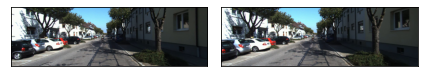

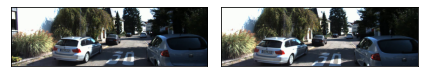

In [245]:
# test plot() and view test batches
plot(batch1)
plot(batch2)

In [246]:
# # function to normalize images for large raft model
def preprocess(imgs1,imgs2):
    weights = Raft_Large_Weights.DEFAULT # import default weights for raft large NN
    transforms = weights.transforms() # define transforms to normalize image input
    imgs1 = F.resize(imgs1,size=[520,960]) # prepare batch 1 for transforms
    imgs2 = F.resize(imgs2,size=[520,960]) # prepare batch 2 for transforms
    return transforms(imgs1,imgs2) # return transforms to input into model

In [247]:
batch1, batch2 = preprocess(batch1,batch2) # preprocess batches 0, 1, 2
batch1.shape, batch2.shape # verify the shape before passing through model

(torch.Size([2, 3, 520, 960]), torch.Size([2, 3, 520, 960]))

In [248]:
# make code device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu' # use gpu if available otherwise cpu
device # print device

'cpu'

In [249]:
# create the model
raft = raft_large(weights=Raft_Large_Weights.DEFAULT,progress=False).to(device) # initialize model and send to device
raft = raft.eval() # place model in test mode

test_outputs = raft(batch1.to(device),batch2.to(device)) # view model output of test batches
print(f"type = {type(test_outputs)}") # preview the data type of test_outputs
print(f"length = {len(test_outputs)} = number of iterations of the model") # view length of list

type = <class 'list'>
length = 12 = number of iterations of the model


In [250]:
flows = test_outputs[-1] # take the last iteration of predicted flow
print(f"dtype = {flows.dtype}") # check the data type
print(f"shape = {flows.shape} = (N, 2, H, W)") # check the shape
print(f"min = {flows.min()}, max = {flows.max()}") # view max and min value corresponding to flow

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -40.38019561767578, max = 297.1819763183594


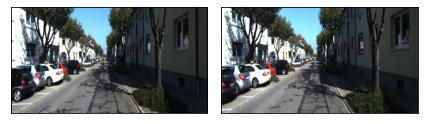

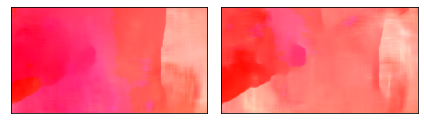

In [251]:
flow_imgs = flow_to_image(flows) # convert flows to a new format for plotting
plot((batch1+1)/2) # change pixel values back to range [0,1] and plot
plot(flow_imgs) # plot the predicted flows from the model

In [269]:
# store frame by frame flows into a folder to create a output video
for i, (img1, img2) in enumerate(zip(frames, frames[1:])): # iterate through the images
    img1, img2 = preprocess(img1, img2) # images to create the flow from
    img1,img2 = img1.unsqueeze(0),img2.unsqueeze(0) # add an extra dimension to the images for the model
    # print(img1.shape,img2.shape) # used for debugging
    raft_outputs = raft(img1.to(device), img2.to(device)) # send the images to model to find flow
    flow = raft_outputs[-1][0] # take only the most recent iteration and only the first flow image
    flow_img = flow_to_image(flow) # convert the flow to an image format from tensor
    # print(flow_img.shape) # used for debugging
    # plot(flow_img) # used for debugging and verifying output
    output_folder = "/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/flows/"  # save images here
    write_png(flow_img, output_folder + f"flow_img{i}.png") # save flow image as png to folder
    if i % 10 == 0: # print the progress every so often
        print(f"{i} / {len(frames)}")

0 / 201
10 / 201
20 / 201
30 / 201
40 / 201
50 / 201
60 / 201
70 / 201
80 / 201
90 / 201
100 / 201
110 / 201
120 / 201
130 / 201
140 / 201
150 / 201
160 / 201
170 / 201
180 / 201
190 / 201


In [288]:
# index through images and create array to form mp4 for flows
flow_dir = '/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/flows/' # directory
flow_imgs = [] # array for images in order
for i in range(200): # loop to append images to array in order
    flow_out = flow_dir + "flow_img%d.png" % i
    flow_imgs.append(flow_out)
print(len(flow_imgs)) # verify length
print(flow_imgs[0:3]) # verify first few images
print(flow_imgs[198:200]) # verify last few images

200
['/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/flows/flow_img0.png', '/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/flows/flow_img1.png', '/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/flows/flow_img2.png']
['/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/flows/flow_img198.png', '/Users/JonathanCrowell/Desktop/Desktop/Jupyter/Robotics/flows/flow_img199.png']


In [290]:
flow_img_shape = cv2.imread(flow_imgs[0]) # shape of image/frame to build mp4
flow_img_shape.shape # check shape
fh,fw,fc = flow_img_shape.shape # store dimensions into variables for VideoWriter()
print(fh,fw,fc) # check shape

520 960 3


In [291]:
flow_vid = 'flows.mp4' # variable for saved video

fourcc_flow = cv2.VideoWriter_fourcc(*'mp4v') # codec to save video as mp4

flow_video = cv2.VideoWriter(flow_vid, fourcc_flow, 30, (fw,fh)) # write video using this function (output name, codec, fps, image shape)

for i in flow_imgs: # loop to write all images to video
    flow_video.write(cv2.imread(i))

cv2.destroyAllWindows() # close windows and release video from opencv when finished
flow_video.release()

In [298]:
flow_vid = cv2.VideoCapture('flows.mp4') # create variable for video

while(flow_vid.isOpened()): # read video
  ret, frame = flow_vid.read() # value for boolean and frame return
  if ret == True: # if bool is true
    cv2.imshow('flows.mp4',frame) # print the frame
 
    if cv2.waitKey(25) & 0xFF == ord('z'): # stop play if q is pressed
      break
 
  else: # close loop
    break
 
flow_vid.release() # release video and close all windows for opencv
cv2.destroyAllWindows()

In [301]:
pip list # print out libraries and versions contained in this conda venv

Package                       Version
----------------------------- -----------
absl-py                       1.2.0
anyio                         3.6.1
appnope                       0.1.3
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.0.8
attrs                         22.1.0
av                            10.0.0
Babel                         2.10.3
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.11.1
bleach                        5.0.1
box2d-py                      2.3.5
brotlipy                      0.7.0
certifi                       2022.9.24
cffi                          1.15.1
charset-normalizer            2.0.4
cloudpickle                   2.2.0
contourpy                     1.0.5
cryptography                  37.0.1
cycler                        0.11.0
Cython                        0.29.32
decorator                     5.1.1
defusedxml                    0.7.1
entry